In [1]:
import librosa
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

Using TensorFlow backend.


In [2]:
DATA_PATH="./data_init/"

def get_labels(path=DATA_PATH):
    labels=os.listdir(path)
    label_indices=np.arange(0,len(labels))
    return labels, label_indices, to_categorical(label_indices)

In [3]:
def speech2mfcc(file_path,max_len=11):
    wave, sr= librosa.load(file_path, mono=True, sr=None)
    wave=wave[::5]
    mfcc=librosa.feature.mfcc(wave,sr=16000)
    if (max_len > mfcc.shape[1]): #.shape[1], 1-->column
        pad_width=max_len-mfcc.shape[1]
        mfcc=np.pad(mfcc,pad_width=((0,0),(0,pad_width)),mode='constant')
    else:
        mfcc=mfcc[:,:max_len]
    return mfcc

In [4]:
def save_data_to_array(path=DATA_PATH, max_len=11):
    labels,_,_=get_labels(path)

    for label in labels:
        mfcc_vectors=[]

        speechfiles=[path + label + '/' + speech for speech in os.listdir(path+'/'+label)]
        for speech in tqdm(speechfiles,"Saving vectors to label -'{}'".format(label)):
            mfcc=speech2mfcc(speech,max_len=max_len)
            mfcc_vectors.append(mfcc)
            
        np.save(label+'.npy',mfcc_vectors)

In [5]:
save_data_to_array()

Saving vectors to label -'9': 100%|██████████| 26/26 [00:00<00:00, 39.15it/s]


In [8]:
def get_train_test(split_ratio=0.8,random_state=42):
    labels,indices,_=get_labels(DATA_PATH)

    X=np.load(labels[0]+'.npy')
    y=np.zeros(X.shape[0])

    for i,label in enumerate(labels[1:]):
        x=np.load(label+'.npy')
        X=np.vstack((X,x))
        y=np.append(y,np.full(x.shape[0],fill_value=(i+1)))
    assert X.shape[0] == len(y)
    return train_test_split(X,y,test_size=(1-split_ratio),random_state=random_state,shuffle=True)

In [12]:
X_train, X_test, y_train, y_test=get_train_test()
#print(X_train.shape)
X_train=X_train.reshape(X_train.shape[0],20,11,1)
X_test=X_test.reshape(X_test.shape[0],20,11,1)
y_train_hot=to_categorical(y_train)
y_test_hot=to_categorical(y_test)

In [21]:
X_train.shape

(303, 20, 11, 1)

In [14]:
model=Sequential()
model.add(Conv2D(64,kernel_size=(2,2),activation='tanh',input_shape=(20,11,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10,activation='softmax'))

In [15]:
model.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.Adadelta(),metrics=['accuracy'])
history=model.fit(X_train,y_train_hot,batch_size=128,epochs=20,verbose=1,validation_data=(X_test,y_test_hot))
#history=model.fit(X_train,y_train_hot,batch_size=128,epochs=20,verbose=1)

Train on 208 samples, validate on 52 samples
Epoch 1/20
208/208 [==============================] - 1s 7ms/step - loss: 3.2237 - acc: 0.1202 - val_loss: 2.3762 - val_acc: 0.1346
Epoch 2/20
208/208 [==============================] - 0s 606us/step - loss: 2.7501 - acc: 0.2356 - val_loss: 2.1402 - val_acc: 0.1731
Epoch 3/20
208/208 [==============================] - 0s 617us/step - loss: 1.9728 - acc: 0.2981 - val_loss: 2.0188 - val_acc: 0.2500
Epoch 4/20
208/208 [==============================] - 0s 590us/step - loss: 1.8134 - acc: 0.3221 - val_loss: 1.8252 - val_acc: 0.3462
Epoch 5/20
208/208 [==============================] - 0s 579us/step - loss: 1.5020 - acc: 0.4279 - val_loss: 1.5836 - val_acc: 0.4808
Epoch 6/20
208/208 [==============================] - 0s 626us/step - loss: 1.4073 - acc: 0.5048 - val_loss: 1.4600 - val_acc: 0.5000
Epoch 7/20
208/208 [==============================] - 0s 599us/step - loss: 1.2173 - acc: 0.5529 - val_loss: 1.2019 - val_acc: 0.5962
Epoch 8/20
208/208 

In [24]:
history_dict=history.history
final_loss=history_dict['loss'][-1]
final_acc=history_dict['acc'][-1]

In [25]:
final_acc

0.9042904298297643

In [26]:
np.save('./Result/Training_trial7.npy',[final_loss, final_acc])

In [16]:
history_dict=history.history
loss_values=history_dict['loss']
val_loss_values=history_dict['val_loss']
epochs=range(1,len(loss_values)+1)

In [59]:
np.load('./Result/Training_trial5.npy')

array([0.17341404, 0.93333334])

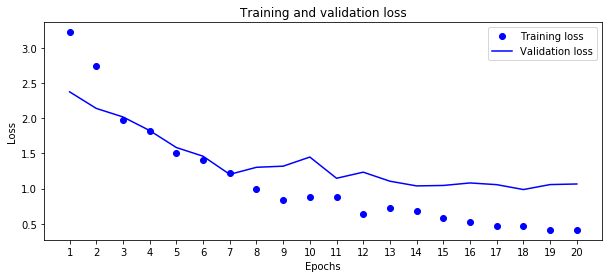

In [17]:
plt.figure(figsize=(10,4))
plt.plot(epochs,loss_values,'bo',label='Training loss')
plt.plot(epochs,val_loss_values,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.show()
plt.savefig('loss_20_epochs.svg',format='svg', dpi=1200)

In [19]:
plt.clf()
acc_values=history_dict['acc']
val_acc_values=history_dict['val_acc']

<Figure size 432x288 with 0 Axes>

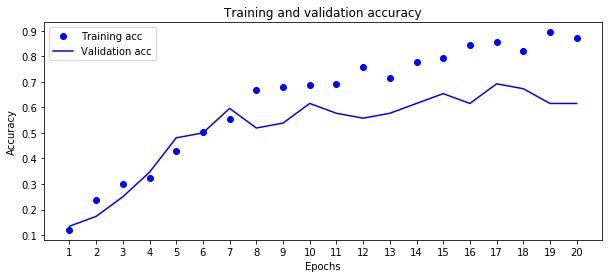

In [20]:
plt.figure(figsize=(10,4))
plt.plot(epochs,acc_values,'bo',label='Training acc')
plt.plot(epochs,val_acc_values,'b',label='Validation acc')
plt.title('Training and validation accuracy')
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
#plt.show()
plt.savefig('accuracy_20_epochs.svg',format='svg', dpi=1200)

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 19, 10, 64)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 5, 64)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 9, 5, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2880)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               368768    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total para